# Imports

In [130]:
#!pip install -U scikit-learn

In [131]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [132]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [133]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [134]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [135]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [136]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[20.81144658 20.81680621 20.81149851 ...  6.53810472 18.76141016
  6.53921003]
[20.43057045 20.43583199 20.43062143 ...  6.41844903 18.41805232
  6.41953411]
[0.99999961 0.99999961 0.99999961 ... 0.99036903 0.99999832 0.9903765 ]
(5999,)


### Multinomial Sampling

In [137]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [138]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(77.56496, 6.5098743, 2.4930878), (81.16858, 8.78582, 86.75421), (80.20638, -3.5589852, 97.223595), (79.978134, -7.9794145, 82.25813), (90.73905, -5.4119864, 29.6), (39.0, 8.294318, 87.05988), (77.15732, 8.610001, 87.839554), (88.39408, -4.1574683, 90.931366), (84.133, 8.793697, 29.6), (78.21332, -8.798424, -4.570979), (75.0, 5.2797017, 97.04022), (76.01672, 7.328478, 84.99445), (75.9849, 5.0095077, 2.5837455), (51.0, 8.793697, 89.66699), (79.06786, 7.4193583, 16.7), (92.08002, 2.3044074, 1.0947912), (78.95849, 7.8332825, 93.38299), (76.429726, -5.0095077, 3.1634462), (75.74507, -6.5098743, 83.98063), (87.501465, 7.5075808, 85.99886), (85.928276, -8.535009, 3.2272732), (75.66222, -8.447791, 87.50058), (78.500145, 7.328478, 82.98341), (78.25767, -6.8353896, 16.7), (78.77108, -7.6759295, 83.64897), (81.73393, -4.1574683, -11.324654), (83.278, -4.1574683, 95.53791), (88.09826, 7.5075808, 1.0158784), (79.3094, 7.138877, 94.46298), (83.28927, -8.78582, 3.365578), (77.27036, -8.447791, 87.1

# KNN

In [139]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[77.56496, 6.5098743, 2.4930878], [81.16858, 8.78582, 86.75421], [80.20638, -3.5589852, 97.223595], [79.978134, -7.9794145, 82.25813], [90.73905, -5.4119864, 29.6], [39.0, 8.294318, 87.05988], [77.15732, 8.610001, 87.839554], [88.39408, -4.1574683, 90.931366], [84.133, 8.793697, 29.6], [78.21332, -8.798424, -4.570979], [75.0, 5.2797017, 97.04022], [76.01672, 7.328478, 84.99445], [75.9849, 5.0095077, 2.5837455], [51.0, 8.793697, 89.66699], [79.06786, 7.4193583, 16.7], [92.08002, 2.3044074, 1.0947912], [78.95849, 7.8332825, 93.38299], [76.429726, -5.0095077, 3.1634462], [75.74507, -6.5098743, 83.98063], [87.501465, 7.5075808, 85.99886], [85.928276, -8.535009, 3.2272732], [75.66222, -8.447791, 87.50058], [78.500145, 7.328478, 82.98341], [78.25767, -6.8353896, 16.7], [78.77108, -7.6759295, 83.64897], [81.73393, -4.1574683, -11.324654], [83.278, -4.1574683, 95.53791], [88.09826, 7.5075808, 1.0158784], [79.3094, 7.138877, 94.46298], [83.28927, -8.78582, 3.365578], [77.27036, -8.447791, 87.1

In [140]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [141]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  5


Number of nodes: 50
Number of edges: 190


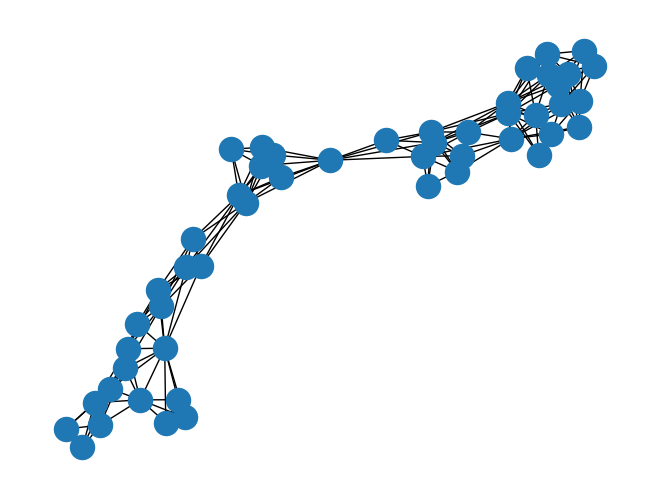

In [142]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [143]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [144]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\Arthur\AppData\Local\Temp\ipykernel_6596\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

#### Inputs

In [145]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)



  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 23)	1
  (0, 24)	1
  (0, 31)	1
  (0, 34)	1
  (0, 37)	1
  (0, 38)	1
  (0, 39)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 34)	1
  (1, 38)	1
  (1, 39)	1
  (1, 48)	1
  (2, 0)	1
  (2, 1)	1
  (2, 3)	1
  (2, 4)	1
  (2, 32)	1
  (2, 35)	1
  :	:
  (45, 16)	1
  (45, 17)	1
  (45, 18)	1
  (45, 30)	1
  (45, 42)	1
  (46, 2)	1
  (46, 32)	1
  (46, 33)	1
  (46, 35)	1
  (46, 38)	1
  (46, 47)	1
  (47, 2)	1
  (47, 32)	1
  (47, 33)	1
  (47, 35)	1
  (47, 38)	1
  (47, 46)	1
  (48, 1)	1
  (48, 3)	1
  (48, 4)	1
  (48, 34)	1
  (49, 19)	1
  (49, 21)	1
  (49, 22)	1
  (49, 24)	1
[[0.24126541 0.53143231 0.40679251 ... 0.8335316  0.25055664 0.72510346]
 [0.56306639 0.10284615 0.25721774 ... 0.40681974 0.15638641 0.71351449]
 [0.45560586 0.77714855 0.70872117 ... 0.00822922 0.21960787 0.63611991]
 ...
 [0.7725006  0.91575608 0.74487935 ... 0.88245705 0.41859017 0.65744674]
 [0.33618606 0.27484221 0.29555238 ... 0.71401873 0.4609432  0.20974782]
 [0.29624194 0.5

In [146]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[ 92.57608435 103.99439733  93.48322251 ... 110.29148606  83.8432414
   88.63064481]
 [103.99439733 118.72138139 103.78081192 ... 124.08226731  95.77525655
   96.50379777]
 [ 93.48322251 103.78081192  94.52161788 ... 111.0998626   84.23841288
   90.29899831]
 ...
 [110.29148606 124.08226731 111.0998626  ... 131.08479235 101.26646163
  103.71073361]
 [ 83.8432414   95.77525655  84.23841288 ... 101.26646163  75.72873414
   77.45626615]
 [ 88.63064481  96.50379777  90.29899831 ... 103.71073361  77.45626615
   79.00691514]]
(50, 50)


c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [147]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(triangles[0])

[[(77.56496, 6.5098743, 2.4930878), (75.9849, 5.0095077, 2.5837455), (88.09826, 7.5075808, 1.0158784)], [(77.56496, 6.5098743, 2.4930878), (75.9849, 5.0095077, 2.5837455), (75.54791, -4.4479885, 2.7246575)], [(77.56496, 6.5098743, 2.4930878), (75.9849, 5.0095077, 2.5837455), (76.429726, -5.0095077, 3.1634462)], [(77.56496, 6.5098743, 2.4930878), (75.9849, 5.0095077, 2.5837455), (76.5894, -5.5423326, 2.645231)], [(77.56496, 6.5098743, 2.4930878), (75.9849, 5.0095077, 2.5837455), (89.470695, 6.7292814, 3.8)], [(77.56496, 6.5098743, 2.4930878), (75.9849, 5.0095077, 2.5837455), (92.08002, 2.3044074, 1.0947912)], [(77.56496, 6.5098743, 2.4930878), (88.09826, 7.5075808, 1.0158784), (75.54791, -4.4479885, 2.7246575)], [(77.56496, 6.5098743, 2.4930878), (88.09826, 7.5075808, 1.0158784), (76.429726, -5.0095077, 3.1634462)], [(77.56496, 6.5098743, 2.4930878), (88.09826, 7.5075808, 1.0158784), (92.08002, 2.3044074, 1.0947912)], [(77.56496, 6.5098743, 2.4930878), (88.09826, 7.5075808, 1.0158784), 

#### Calculate barycenter

#### Calculate r

#### Calculate f

# Simplified Mesh